# LAB 4: Transfer Learning and Visualizations


> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.



## Step 1: Install missing dependencies and import libraries

In [1]:
# Install missing dependencies
!pip install -q torchinfo torchmetrics wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.9/960.9 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.2 MB/s eta 0:00:00


In [2]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

from torchinfo import summary

import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Step 2: plot a confusion matrix of the predictions on the test set

### Get data

In [4]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
!mkdir -p data
!unzip -n pizza_steak_sushi.zip -d data/pizza_steak_sushi

--2025-04-01 14:16:50--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2025-04-01 14:16:51--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.08s   

2025-04-01 14:16:51 (179 MB/s) - ‘pizza_steak

### Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [22]:
# Create training and testing DataLoader's as well as get a list of class names

data_path = "data/pizza_steak_sushi"
train_dset = ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset = ImageFolder(f"{data_path}/test", transform=simple_transform)
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")


train_dataloader = DataLoader(train_dset, batch_size=32, num_workers=0, shuffle=True)
test_dataloader = DataLoader(test_dset, batch_size=32, num_workers=0)

train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'sushi', 'steak']


(<torch.utils.data.dataloader.DataLoader at 0x7d74f4ef4810>,
 ['pizza', 'sushi', 'steak'])

### Get and prepare a pretrained model

In [7]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device) # EfficientNet-B0 model
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 128MB/s]


In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=1e-3)

In [30]:
def train(model, train_loader, criterion, optimizer): # criterion = loss

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader): #(X,y)
        inputs, targets = inputs.cuda(), targets.cuda() # GPU

        # Compute prediction and loss
        outputs = model(inputs) # Contains the prediction of the model of the current batch
        # outputs contains for each row the tuple (class, prob)
        loss = criterion(outputs, targets)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Update of the loss = contain the total loss of the epoch
        _, predicted = outputs.max(1) # Predicted class
        # outputs.max(0) = the maximum value for each row
        # outputs.max(1) = the predicted class
        total += targets.size(0) # Number of element in the current batch, in total there is the total number of processated batch
        correct += predicted.eq(targets).sum().item() # Sum of correctly predicted element

    train_loss = running_loss / len(train_loader) # Mean loss of the all dataset
    train_accuracy = 100. * correct / total

    # print(f'TLoss: {train_loss:.6f} Acc: {train_accuracy:.2f}%') # epoch = is the current epoch

In [39]:
# Test loop
def test(model, val_loader, criterion):
    model.eval()
    val_loss = 0

    correct, total = 0, 0

    all_targets = torch.tensor([]).to(device)
    all_predicts = torch.tensor([]).to(device)
    all_probabilities = torch.tensor([]).to(device)

    with torch.no_grad(): # NOT compute the gradient (we already computed in the previous step)
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.cuda(), targets.cuda()

            all_targets = torch.cat((all_targets, targets), dim=0)

            outputs = model(inputs) # Predicted
            loss = criterion(outputs, targets) # Computation of the loss

            # As computed in the train part
            val_loss += loss.item()

            probabilities = torch.softmax(outputs, dim=1) # Probability of each class
            predicted = torch.argmax(probabilities, dim=1) # Predicted class

            all_predicts = torch.cat((all_predicts, predicted), dim=0)
            all_probabilities = torch.cat((all_probabilities, probabilities), dim=0)

            total += targets.size(0)
            correct += predicted.eq(targets).sum().item() # In targets there are all the real label

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # print(f'Validation Loss: {val_loss:.6f} Acc: {val_accuracy:.2f}%')
    return val_accuracy, all_targets, all_predicts, all_probabilities

In [40]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
for i in range(50):
    train(model_0, train_dataloader, loss_fn, optimizer)
    test_acc, all_targets, all_predicts, all_probabilities = test(model_0, test_dataloader, loss_fn)
    # print(f"Epoch: {i} - Test accuracy: {test_acc}")  # You should get values around 90% accuracy on the test set


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

[INFO] Total training time: 94.901 seconds


### Make a confusion matrix with the test preds and the truth labels

HINT: Look at the torchmetrics.functional.classification.multiclass_confusion_matrix from the torchmetrics library

In [41]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

# compute confusion matrix
cm = multiclass_confusion_matrix(all_targets, all_predicts, num_classes=3)
cm

tensor([[21,  0,  0],
        [ 1, 18,  1],
        [ 3,  1, 30]], device='cuda:0')

## Step 3: Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [42]:
# Create a DataFrame with sample, label, prediction, pred pro
import pandas as pd
df = pd.DataFrame(columns=['label', 'prediction', 'pred_prob'])
df['label'] = all_targets.cpu().numpy()
df['prediction'] = all_predicts.cpu().numpy()
df['pred_prob'] = all_probabilities.cpu().numpy()
df['correct'] = df['label'] == df['prediction']

In [43]:
df

,label,prediction,pred_prob,correct
0,0.0,0.0,0.931284,True
1,0.0,0.0,0.997179,True
2,0.0,0.0,0.945439,True
3,0.0,0.0,0.998971,True
4,0.0,0.0,0.984681,True
...,...,...,...,...
70,2.0,1.0,0.002318,False
71,2.0,2.0,0.000931,True
72,2.0,2.0,0.023239,True
73,2.0,2.0,0.024531,True


In [44]:
# Sort DataFrame by correct (does label == prediction)
df_sorted = df.sort_values(by='correct')
df_sorted

,label,prediction,pred_prob,correct
24,0.0,2.0,0.432136,False
70,2.0,1.0,0.002318,False
34,1.0,2.0,0.004091,False
15,0.0,2.0,0.290659,False
13,0.0,2.0,0.339161,False
...,...,...,...,...
25,1.0,1.0,0.000003,True
23,0.0,0.0,0.999034,True
22,0.0,0.0,0.979511,True
29,1.0,1.0,0.009909,True


In [45]:
# Sort DataFrame by pred prob (descending)
df_sorted = df_sorted.sort_values(by='pred_prob', ascending=False)
df_sorted

,label,prediction,pred_prob,correct
9,0.0,0.0,9.997237e-01,True
6,0.0,0.0,9.997000e-01,True
19,0.0,0.0,9.992049e-01,True
23,0.0,0.0,9.990336e-01,True
3,0.0,0.0,9.989712e-01,True
...,...,...,...,...
61,2.0,2.0,1.502494e-06,True
54,2.0,2.0,9.993880e-07,True
36,1.0,1.0,5.852394e-07,True
48,2.0,2.0,1.621490e-07,True


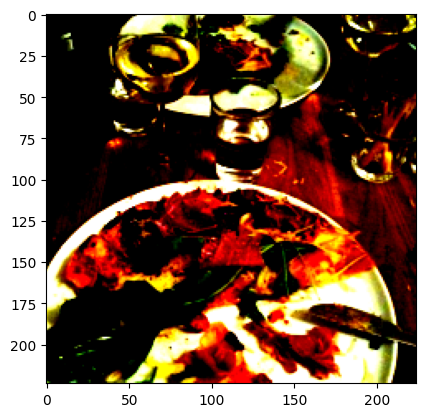

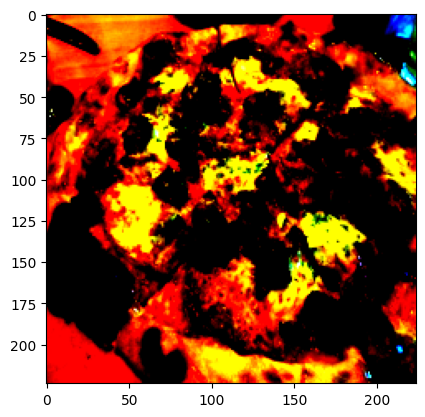

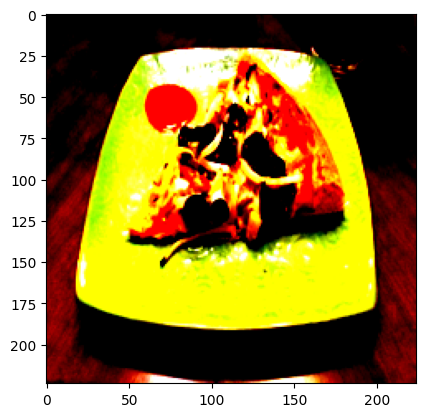

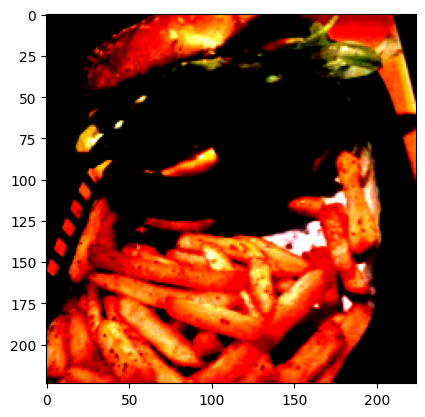

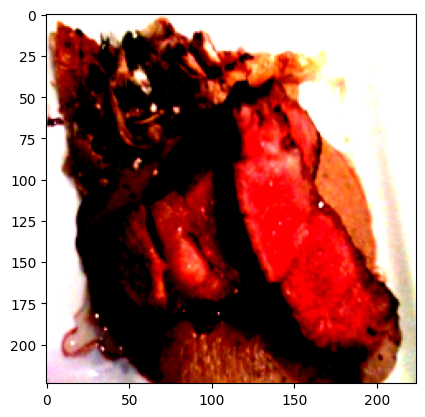

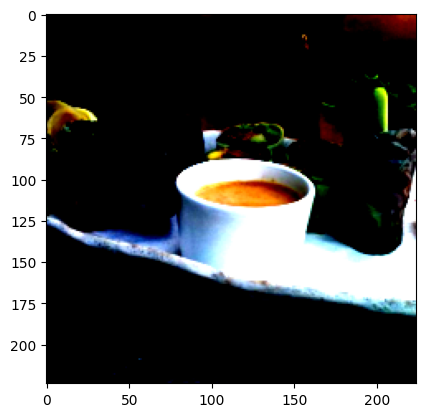

In [46]:
# Plot the top 5 "most wrong" image predictions
import numpy as np

wrong_pred = df_sorted[df_sorted['correct'] == False].index
wrong_pred

for i in wrong_pred:
  image, label = test_dset[i]
  plt.imshow(image.numpy().transpose((1,2,0)))
  plt.show()

## Step 4: Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [48]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
!mkdir -p data
!unzip pizza_steak_sushi_20_percent.zip -d data/pizza_steak_sushi_20_percent

--2025-04-01 16:25:18--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi_20_percent.zip [following]
--2025-04-01 16:25:18--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi_20_percent.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31491084 (30M) [application/zip]
Saving to: ‘pizza_steak_sushi_20_percent.zip’

pizza_steak_sushi_2 100%[===================>]  30.03M  --.-KB/s    in 0.1s    

2

### Create DataLoaders

In [49]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [50]:
# Create training and testing DataLoader's as well as get a list of class names

data_path = "data/pizza_steak_sushi"
train_dset_20p= ImageFolder(f"{data_path}/train", transform=simple_transform)
test_dset_20p = ImageFolder(f"{data_path}/test", transform=simple_transform)
class_names = list(os.listdir(f"{data_path}/train"))  # 'pizza', 'steak', 'sushi'
print(f"Class names: {class_names}")


train_dataloader_20p = DataLoader(train_dset_20p, batch_size=32, num_workers=2, shuffle=True)
test_dataloader_20p = DataLoader(test_dset_20p, batch_size=32, num_workers=2)

# train_dataloader, test_dataloader, class_names

Class names: ['pizza', 'sushi', 'steak']


### Get a pretrained model

In [52]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
for i in range(50):
    train(model_0, train_dataloader_20p, loss_fn, optimizer)
    test_acc, all_targets, all_predicts, all_probabilities = test(model_0, test_dataloader_20p, loss_fn)
    # print(f"Epoch: {i} - Test accuracy: {test_acc}")  # You should get values around 90% accuracy on the test set


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

[INFO] Total training time: 96.154 seconds


In [53]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

# compute confusion matrix
cm = multiclass_confusion_matrix(all_targets, all_predicts, num_classes=3)
cm

tensor([[21,  0,  0],
        [ 1, 18,  1],
        [ 3,  1, 30]], device='cuda:0')

In [54]:
# Create a DataFrame with sample, label, prediction, pred pro
import pandas as pd
df = pd.DataFrame(columns=['label', 'prediction', 'pred_prob'])
df['label'] = all_targets.cpu().numpy()
df['prediction'] = all_predicts.cpu().numpy()
df['pred_prob'] = all_probabilities.cpu().numpy()
df['correct'] = df['label'] == df['prediction']

df

,label,prediction,pred_prob,correct
0,0.0,0.0,0.937343,True
1,0.0,0.0,0.997981,True
2,0.0,0.0,0.949574,True
3,0.0,0.0,0.999150,True
4,0.0,0.0,0.986711,True
...,...,...,...,...
70,2.0,1.0,0.001863,False
71,2.0,2.0,0.000782,True
72,2.0,2.0,0.020371,True
73,2.0,2.0,0.019668,True


<ipython-input-60-ac658e279526>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  wrong_pred = df[df_sorted['correct'] == False].index


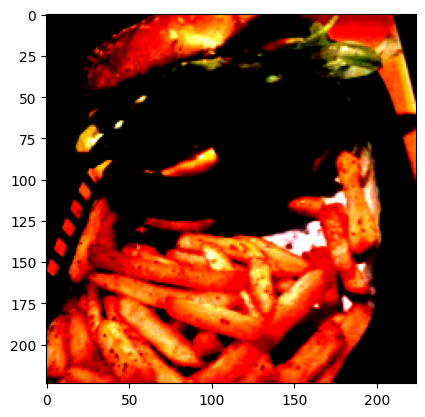

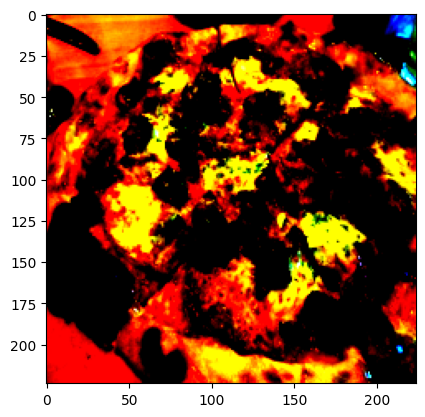

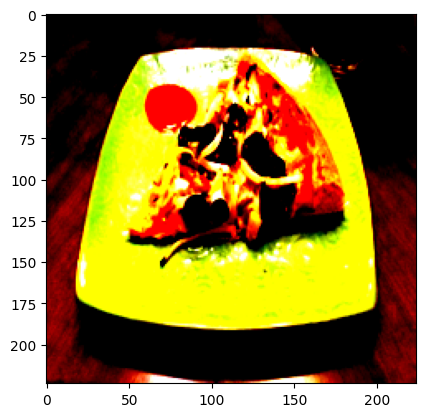

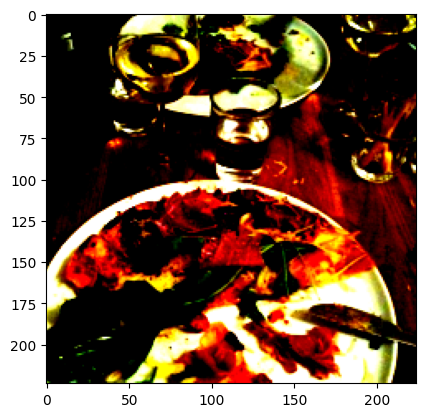

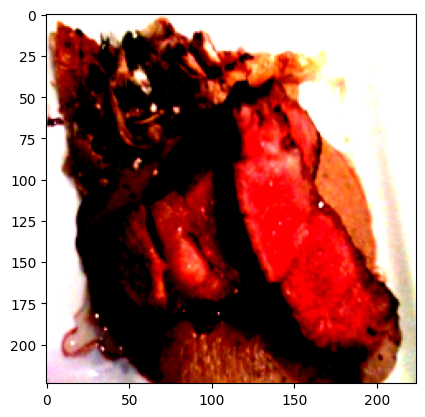

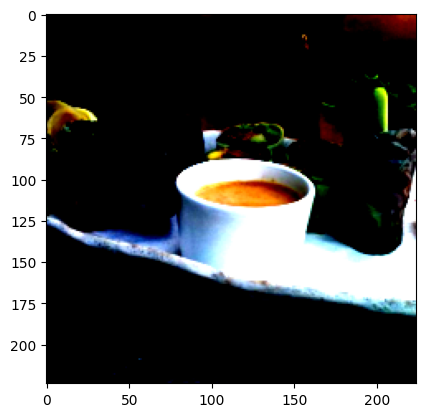

In [60]:
# Plot the top 5 "most wrong" image predictions
import numpy as np

df_sorted = df.sort_values(by='correct', ascending=False)
wrong_pred = df[df_sorted['correct'] == False].index
wrong_pred

for i in wrong_pred:
  image, label = test_dset_20p[i]
  plt.imshow(image.numpy().transpose((1,2,0)))
  plt.show()

### Train a model with 20% of the data

In [ ]:
# Already done up

## Step 5: Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [61]:
# Try a different model from torchvision.models
new_model = torchvision.models.efficientnet_b2(pretrained=True).to(device) # EfficientNet-B2 modelg)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [62]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in new_model.features.parameters():
    param.requires_grad = False

In [72]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
new_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [65]:
# Define loss and optimizer
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-3)

In [77]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
for i in range(50):
    train(new_model, train_dataloader, loss_fn, optimizer)
    test_acc, all_targets, all_predicts, all_probabilities = test(new_model, test_dataloader, loss_fn)
    print(f"Epoch: {i} - Test accuracy: {test_acc}")  # You should get values around 90% accuracy on the test set


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Epoch: 0 - Test accuracy: 28.0
Epoch: 1 - Test accuracy: 25.333333333333332
Epoch: 2 - Test accuracy: 25.333333333333332
Epoch: 3 - Test accuracy: 26.666666666666668
Epoch: 4 - Test accuracy: 22.666666666666668
Epoch: 5 - Test accuracy: 28.0
Epoch: 6 - Test accuracy: 25.333333333333332
Epoch: 7 - Test accuracy: 24.0
Epoch: 8 - Test accuracy: 26.666666666666668
Epoch: 9 - Test accuracy: 24.0
Epoch: 10 - Test accuracy: 28.0
Epoch: 11 - Test accuracy: 26.666666666666668
Epoch: 12 - Test accuracy: 25.333333333333332
Epoch: 13 - Test accuracy: 22.666666666666668
Epoch: 14 - Test accuracy: 26.666666666666668
Epoch: 15 - Test accuracy: 25.333333333333332
Epoch: 16 - Test accuracy: 29.333333333333332
Epoch: 17 - Test accuracy: 28.0
Epoch: 18 - Test accuracy: 29.333333333333332
Epoch: 19 - Test accuracy: 29.333333333333332
Epoch: 20 - Test accuracy: 26.666666666666668
Epoch: 21 - Test accuracy: 25.333333333333332
Epoch: 22 - Test accuracy: 30.666666666666668
Epoch: 23 - Test accuracy: 33.333333

In [74]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

# compute confusion matrix
cm = multiclass_confusion_matrix(all_targets, all_predicts, num_classes=3)
cm

tensor([[ 4,  7, 12],
        [ 6,  3, 10],
        [15,  9,  9]], device='cuda:0')

In [75]:
# Create a DataFrame with sample, label, prediction, pred pro
import pandas as pd
df = pd.DataFrame(columns=['label', 'prediction', 'pred_prob'])
df['label'] = all_targets.cpu().numpy()
df['prediction'] = all_predicts.cpu().numpy()
df['pred_prob'] = all_probabilities.cpu().numpy()
df['correct'] = df['label'] == df['prediction']

df

,label,prediction,pred_prob,correct
0,0.0,2.0,0.305410,False
1,0.0,2.0,0.315662,False
2,0.0,1.0,0.266158,False
3,0.0,2.0,0.323767,False
4,0.0,2.0,0.274713,False
...,...,...,...,...
70,2.0,0.0,0.363985,False
71,2.0,2.0,0.310960,True
72,2.0,2.0,0.235151,True
73,2.0,0.0,0.382474,False


In [76]:
# Plot the top 5 "most wrong" image predictions
import numpy as np

df_sorted = df.sort_values(by='correct', ascending=False)
wrong_pred = df[df_sorted['correct'] == False].index
wrong_pred

for i in wrong_pred:
  image, label = test_dset_20p[i]
  plt.imshow(image.numpy().transpose((1,2,0)))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.